In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [6]:
# Load individual datasets
# Load individual datasets
products_df = pd.read_excel('/content/drive/MyDrive/olist_products_dataset.xlsx')
order_items_df = pd.read_csv('/content/drive/MyDrive/olist_order_items_dataset.csv')
olist_orders_df= pd.read_csv('/content/drive/MyDrive/olist_orders_dataset.csv')
order_reviews_df = pd.read_excel('/content/drive/MyDrive/olist_order_reviews_dataset_English.xlsx')
olist_customers_df = pd.read_csv('/content/drive/MyDrive/olist_customers_dataset.csv')
order_payments_df = pd.read_csv('/content/drive/MyDrive/olist_order_payments_dataset .csv')
sellers_df = pd.read_csv('/content/drive/MyDrive/olist_sellers_dataset.csv')
geolocation_df=pd.read_csv("/content/drive/MyDrive/olist_geolocation_dataset.csv")
date_cols=['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']

In [7]:
olist_orders_df.info()
order_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 

In [8]:
def overview_data(dataset_name):
    nrows=dataset_name.shape[0]
    ncols=dataset_name.shape[1]
    null_values = dataset_name.isnull().sum()
    name_nul_cols = []
    for i in range(len(null_values)):
        if null_values[i] >0:
            name_nul_cols.append(null_values.index[i])
    num_nul_cols = len(name_nul_cols)
    return nrows, ncols , name_nul_cols,num_nul_cols

In [9]:
info_db = pd.DataFrame()
list_dataset= [products_df,order_items_df,olist_orders_df,order_reviews_df,olist_customers_df,order_payments_df,sellers_df,geolocation_df]
list_dataset_name= ['products_df','order_items_df','olist_orders_df','order_reviews_df','olist_customers_df','order_payments_df','sellers_df','geolocation_df']
info_db['dataset'] = [i for i in list_dataset_name]
info_db['nrows'] = [overview_data(i)[0] for i in list_dataset]
info_db['ncols'] = [overview_data(i)[1] for i in list_dataset]
info_db['names_of_null_cols'] = [', '.join(overview_data(i)[2]) for i in list_dataset]
info_db['num_null_cols'] = [overview_data(i)[3] for i in list_dataset]
info_db

,dataset,nrows,ncols,names_of_null_cols,num_null_cols
0,products_df,32340,9,,0
1,order_items_df,112650,7,,0
2,olist_orders_df,99441,8,"order_approved_at, order_delivered_carrier_dat...",3
3,order_reviews_df,100000,7,"review_comment_title, review_comment_message",2
4,olist_customers_df,99441,5,,0
5,order_payments_df,103886,5,,0
6,sellers_df,3095,4,,0
7,geolocation_df,1000163,5,,0


In [10]:
orders_info = olist_orders_df.merge(olist_customers_df, on='customer_id', how='left')

In [12]:
orders_info.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state'],
      dtype='object')

In [13]:
order_reviews_df.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

In [14]:
products_df.columns

Index(['product_id', 'product_category_name', 'product_name_length',
       'product_description_length', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

In [15]:
orders_info = order_reviews_df.merge(orders_info, on='order_id', how='left')
orders_info = orders_info.merge(order_items_df, on='order_id', how='left')
orders_info = orders_info.merge( products_df, on='product_id', how='left')
orders_info = orders_info.merge(order_payments_df, on='order_id', how='left')
orders_info = orders_info.merge( sellers_df , on='seller_id', how='left')

In [16]:
# check for duplicates
orders_info.duplicated().sum()

0

In [17]:
# check for missing values by percentage in each column
orders_info.isnull().sum() / len(orders_info) * 100

review_id                         0.000000
order_id                          0.000000
review_score                      0.000000
review_comment_title             88.091581
review_comment_message           57.014209
review_creation_date              0.000000
review_answer_timestamp           0.000000
customer_id                       0.000000
order_status                      0.000000
order_purchase_timestamp          0.000000
order_approved_at                 0.148551
order_delivered_carrier_date      1.750720
order_delivered_customer_date     2.871147
order_estimated_delivery_date     0.000000
customer_unique_id                0.000000
customer_zip_code_prefix          0.000000
customer_city                     0.000000
customer_state                    0.000000
order_item_id                     0.699113
product_id                        0.699113
seller_id                         0.699113
shipping_limit_date               0.699113
price                             0.699113
freight_val

In [18]:
# drop missing values column with more than 50% missing values
orders_info = orders_info.dropna(thresh=len(orders_info) * 0.5, axis=1)
# drop rows with missing values
orders_info =orders_info.dropna()

In [19]:
# check for missing values by percentage in each column
orders_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113782 entries, 0 to 119150
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   review_id                      113782 non-null  object        
 1   order_id                       113782 non-null  object        
 2   review_score                   113782 non-null  int64         
 3   review_creation_date           113782 non-null  datetime64[ns]
 4   review_answer_timestamp        113782 non-null  datetime64[ns]
 5   customer_id                    113782 non-null  object        
 6   order_status                   113782 non-null  object        
 7   order_purchase_timestamp       113782 non-null  object        
 8   order_approved_at              113782 non-null  object        
 9   order_delivered_carrier_date   113782 non-null  object        
 10  order_delivered_customer_date  113782 non-null  object        
 11  order

In [20]:
# Clean and preprocess data
def preprocess_data(df):
    # Drop columns with more than 10% missing values
    df.dropna(thresh=len(df) * 0.1, axis=1, inplace=True)
    # Convert datetime columns
    datetime_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                    'order_delivered_customer_date', 'order_estimated_delivery_date']
    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    # Calculate new features
    df['time_to_delivery'] = (df['order_delivered_customer_date'] - df['order_approved_at']).dt.days
    df['order_processing_time'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.days
    df['estimated_vs_actual_shipping'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days
    df['product_volume_m3'] = (df['product_length_cm'] * df['product_width_cm'] * df['product_height_cm']) / 1000000
    #df['satisfaction'] = (df['review_score'] >= 4).astype(int)
    df['order_value'] = df['price'] + df['freight_value']

    # create late delivery flag
    df['late_delivery'] = (df['order_delivered_customer_date'] > df['order_estimated_delivery_date']).astype(int)
    # Drop rows with missing values
    df.dropna(inplace=True)
    # create seasonal features from order_purchase_timestamp
    df['order_month'] = df['order_purchase_timestamp'].dt.month
    df['order_day'] = df['order_purchase_timestamp'].dt.dayofweek
    df['order_hour'] = df['order_purchase_timestamp'].dt.hour
    return df
orders_info = preprocess_data(orders_info)

In [21]:
orders_info['order_delivered_customer_month'] = orders_info['order_delivered_customer_date'].dt.month
orders_info['order_purchase_month'] = orders_info['order_purchase_timestamp'].dt.month
orders_info['order_purchase_year'] = orders_info['order_purchase_timestamp'].dt.year
orders_info['Delivery Time'] = ((orders_info['order_delivered_customer_date'] - orders_info['order_delivered_carrier_date']))/24

orders_info['is_deliver_ontime']=np.where( orders_info['order_delivered_customer_date'] > orders_info['order_estimated_delivery_date'],0,1)
delivery_ontime_pivot = orders_info[orders_info['order_delivered_customer_date'].isna() == False].groupby('order_delivered_customer_month')['is_deliver_ontime'].agg(TotalDelivered='count',TotalOntime='sum').reset_index()
delivery_ontime_pivot['Ontime Delivery Rate'] = (delivery_ontime_pivot['TotalOntime'] / delivery_ontime_pivot['TotalDelivered'])*100

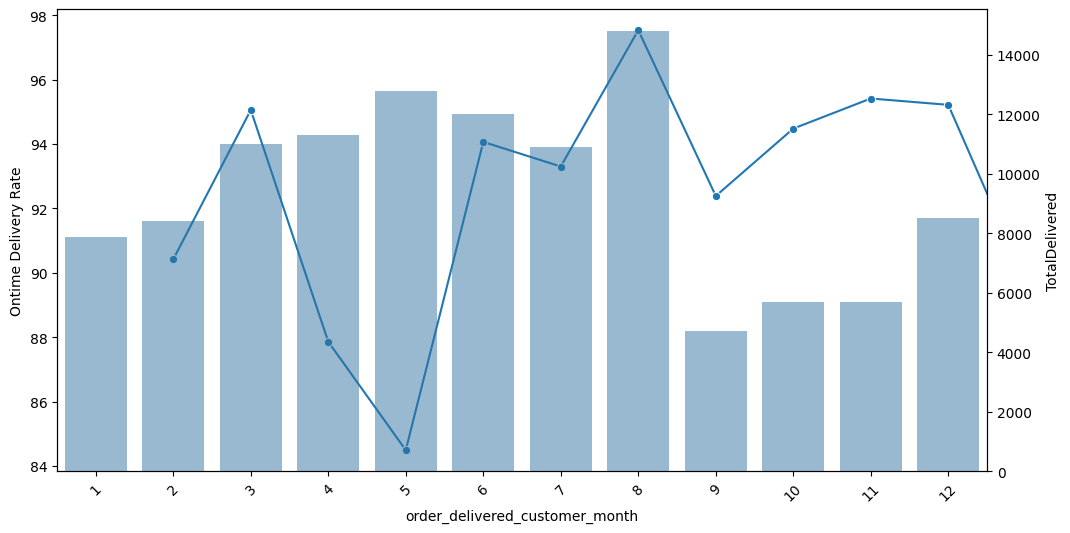

In [22]:
fig, ax1 = plt.subplots(figsize=(12,6))
sns.lineplot(data = delivery_ontime_pivot[delivery_ontime_pivot['Ontime Delivery Rate' ]>0], x = 'order_delivered_customer_month', y='Ontime Delivery Rate', marker='o', ax=ax1)
ax2 = ax1.twinx()
sns.barplot(data = delivery_ontime_pivot[delivery_ontime_pivot['Ontime Delivery Rate' ]>0], x= 'order_delivered_customer_month', y='TotalDelivered', alpha=0.5, ax=ax2)
ax1.tick_params(axis='x', labelrotation = 45)

<Axes: xlabel='customer_state', ylabel='Ontime Delivery Rate'>

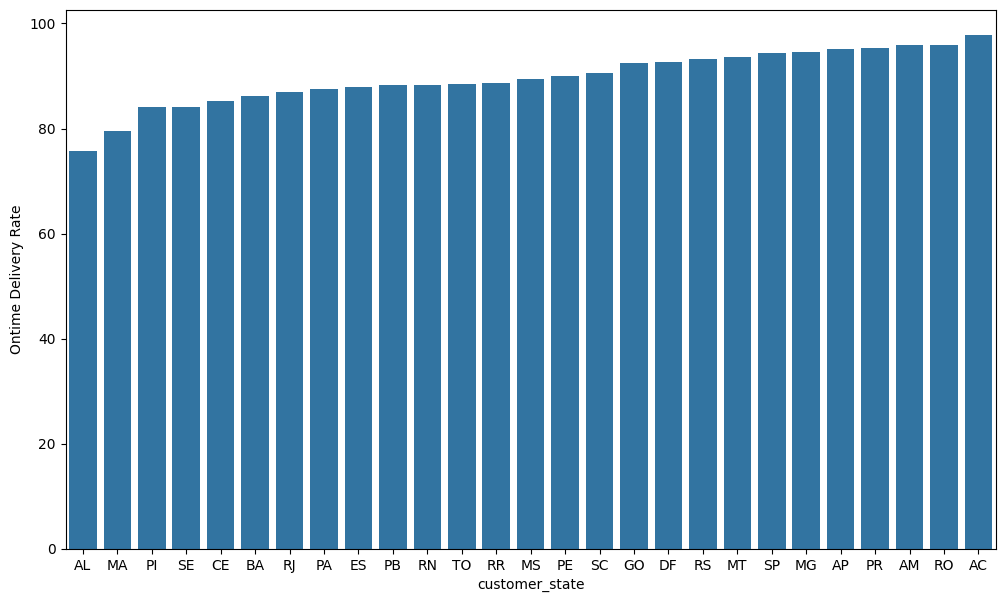

In [23]:
delivery_ontime_by_state = orders_info[orders_info['order_delivered_customer_date'].isna() == False].groupby(['customer_state'])['is_deliver_ontime'].agg(TotalDelivered = 'count',TotalOntime='sum').reset_index()
delivery_ontime_by_state['Ontime Delivery Rate'] =  (delivery_ontime_by_state['TotalOntime'] / delivery_ontime_by_state['TotalDelivered'])*100
delivery_ontime_by_state=delivery_ontime_by_state.sort_values(by='Ontime Delivery Rate')
plt.figure(figsize=(12, 7))
sns.barplot(data =delivery_ontime_by_state, x = 'customer_state', y= 'Ontime Delivery Rate')

In [24]:
avg_delivery_time = orders_info[orders_info['order_delivered_customer_date'].isna() == False].groupby(['order_delivered_customer_month'])['Delivery Time'].agg('mean').reset_index()
delivery_time_and_ontime_rate = avg_delivery_time.merge(delivery_ontime_pivot[delivery_ontime_pivot['Ontime Delivery Rate' ]>0],on='order_delivered_customer_month',how='right')

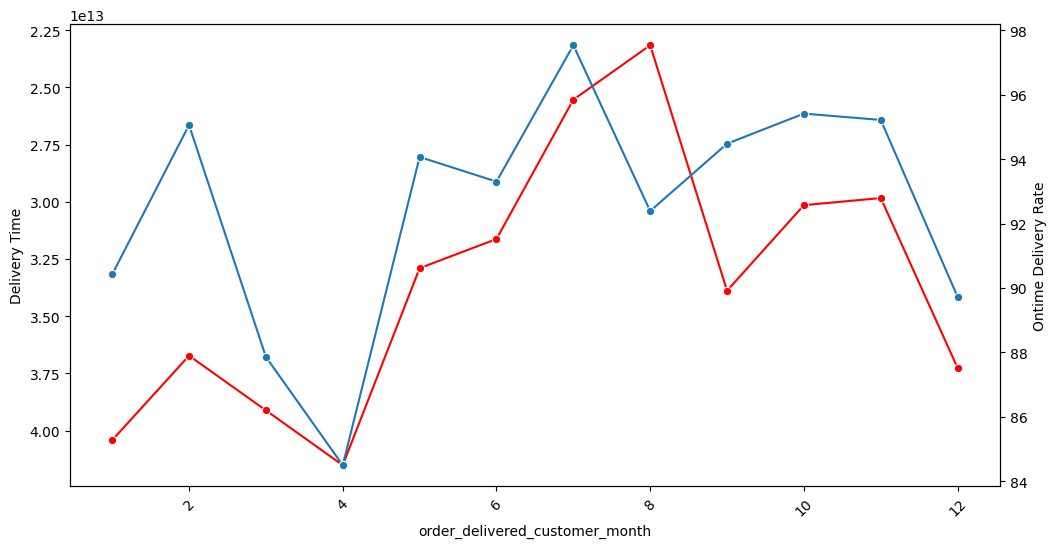

In [25]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax1=sns.lineplot(data= delivery_time_and_ontime_rate,x='order_delivered_customer_month',y='Delivery Time', ax=ax1, color = 'Red',marker='o')
ax2=ax1.twinx()
ax2=sns.lineplot(data = delivery_time_and_ontime_rate, x = 'order_delivered_customer_month', y='Ontime Delivery Rate', marker='o',ax=ax2)
ax1.tick_params(axis='x', labelrotation = 45)

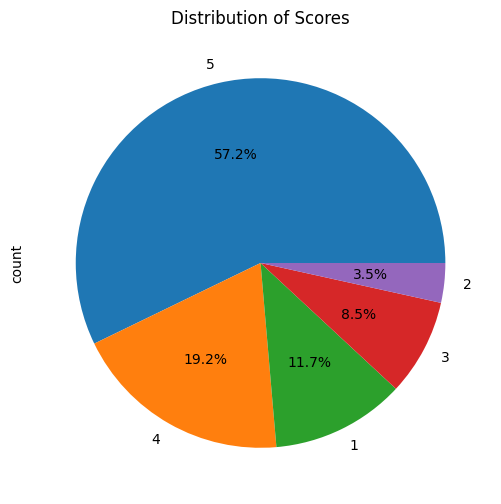

In [26]:
# Distribution of CSAT percentages on pie chart
plt.figure(figsize=(12, 6))
orders_info['review_score'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Scores')
plt.show()

In [27]:
orders_info['satisfaction'] = np.where(orders_info['review_score'] >= 4, 1, 0)

In [28]:
# Check the distribution of the CSAT percentage
orders_info['satisfaction'].value_counts() / len(orders_info) * 100

satisfaction
1    76.367967
0    23.632033
Name: count, dtype: float64

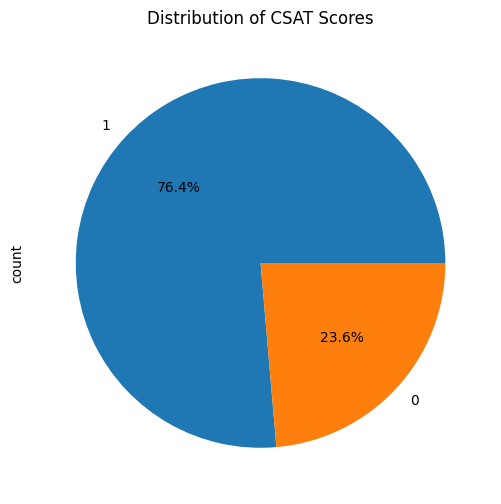

In [29]:
# Distribution of CSAT percentages on pie chart
plt.figure(figsize=(12, 6))
orders_info['satisfaction'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of CSAT Scores')
plt.show()

In [30]:

# check summary statistics
orders_info.describe()

,review_score,review_creation_date,review_answer_timestamp,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,order_item_id,...,late_delivery,order_month,order_day,order_hour,order_delivered_customer_month,order_purchase_month,order_purchase_year,Delivery Time,is_deliver_ontime,satisfaction
count,113782.000000,113782,113782,113782,113782,113782,113782,113782,113782.000000,113782.000000,...,113782.000000,113782.000000,113782.000000,113782.000000,113782.000000,113782.000000,113782.000000,113782,113782.000000,113782.000000
mean,4.066601,2018-01-13 13:03:05.976691968,2018-01-16 16:46:51.687173888,2018-01-01 06:29:25.095823616,2018-01-01 16:55:49.666327040,2018-01-04 13:12:54.286292992,2018-01-13 18:05:47.245504512,2018-01-25 02:43:48.985252608,35072.207757,1.197870,...,0.078167,6.036262,2.745443,14.761667,6.135997,6.036262,2017.541852,0 days 09:12:12.206633811,0.921833,0.763680
min,1.000000,2016-10-15 00:00:00,2016-10-16 03:20:17,2016-10-03 09:44:50,2016-10-04 09:43:32,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-27 00:00:00,1003.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2016.000000,-1 days +07:54:13.791666667,0.000000,0.000000
25%,4.000000,2017-09-26 00:00:00,2017-09-28 01:31:54.750000128,2017-09-13 13:06:22.500000,2017-09-13 21:58:04,2017-09-15 19:53:57.750000128,2017-09-25 18:19:59.249999872,2017-10-04 00:00:00,11310.000000,1.000000,...,0.000000,3.000000,1.000000,11.000000,4.000000,3.000000,2017.000000,0 days 04:03:56.968749999,1.000000,1.000000
50%,5.000000,2018-02-02 00:00:00,2018-02-05 17:52:27.500000,2018-01-20 01:57:29.500000,2018-01-20 15:11:33.500000,2018-01-24 00:04:15.500000,2018-02-02 02:12:09.500000,2018-02-16 00:00:00,24315.000000,1.000000,...,0.000000,6.000000,3.000000,15.000000,6.000000,6.000000,2018.000000,0 days 07:03:44.520833333,1.000000,1.000000
75%,5.000000,2018-05-16 00:00:00,2018-05-20 14:36:06.750000128,2018-05-05 11:05:51,2018-05-05 17:27:38.750000128,2018-05-08 13:58:00,2018-05-15 19:37:06,2018-05-28 00:00:00,58770.000000,1.000000,...,0.000000,8.000000,4.000000,19.000000,8.000000,8.000000,2018.000000,0 days 11:55:48.406249999,1.000000,1.000000
max,5.000000,2018-08-31 00:00:00,2018-10-29 12:27:35,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,99980.000000,21.000000,...,1.000000,12.000000,6.000000,23.000000,12.000000,12.000000,2018.000000,8 days 13:11:27.500000,1.000000,1.000000
std,1.358267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29848.374045,0.703884,...,0.268435,3.222665,1.961210,5.328676,3.164797,3.222665,0.504209,0 days 08:38:06.827307387,0.268435,0.424823


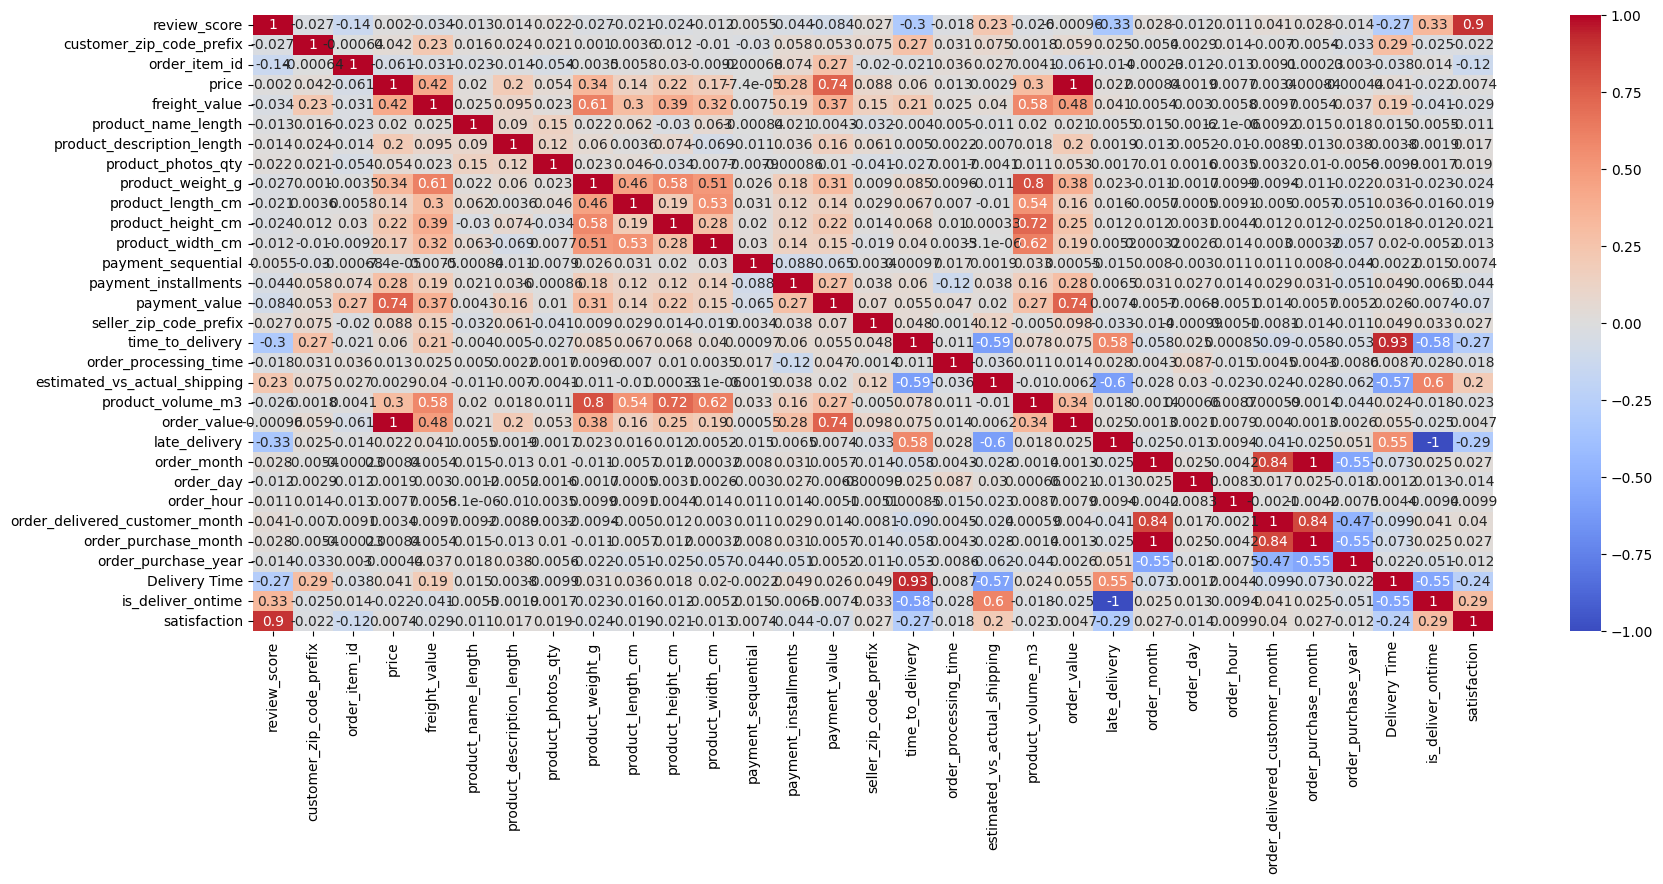

In [31]:
# Select only numeric columns from the DataFrame
numeric_columns = orders_info.select_dtypes(include=[np.number])

# Plot the correlation matrix heatmap with numeric columns
plt.figure(figsize=(20, 8))
sns.heatmap(numeric_columns.corr(), annot=True, cmap='coolwarm')
plt.show()

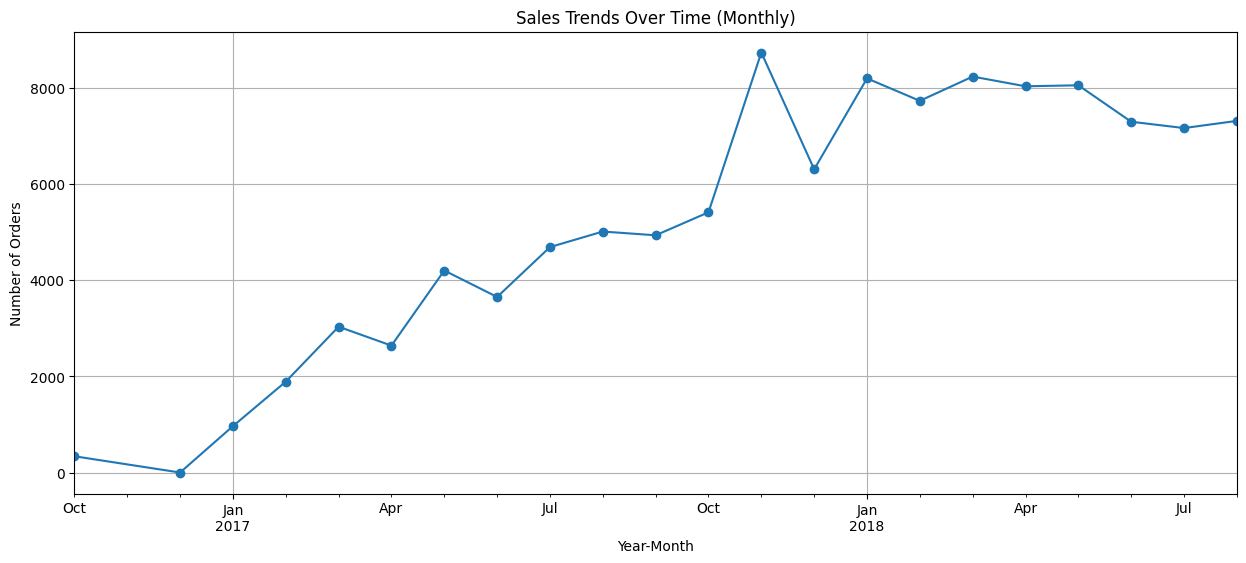

In [32]:
# Ensure that the order_purchase_timestamp is in datetime format
orders_info['order_purchase_timestamp'] = pd.to_datetime(orders_info['order_purchase_timestamp'])

# Extract year and month for aggregation
orders_info['year_month'] = orders_info['order_purchase_timestamp'].dt.to_period('M')

# Aggregate data by year and month
sales_trends = orders_info.groupby('year_month').size()

# Plotting
plt.figure(figsize=(15, 6))
sales_trends.plot(kind='line', marker='o')
plt.title('Sales Trends Over Time (Monthly)')
plt.xlabel('Year-Month')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

<ipython-input-33-63a2b3f5de6e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = category.head(20).index, y = category.head(20).values, palette = 'gnuplot')


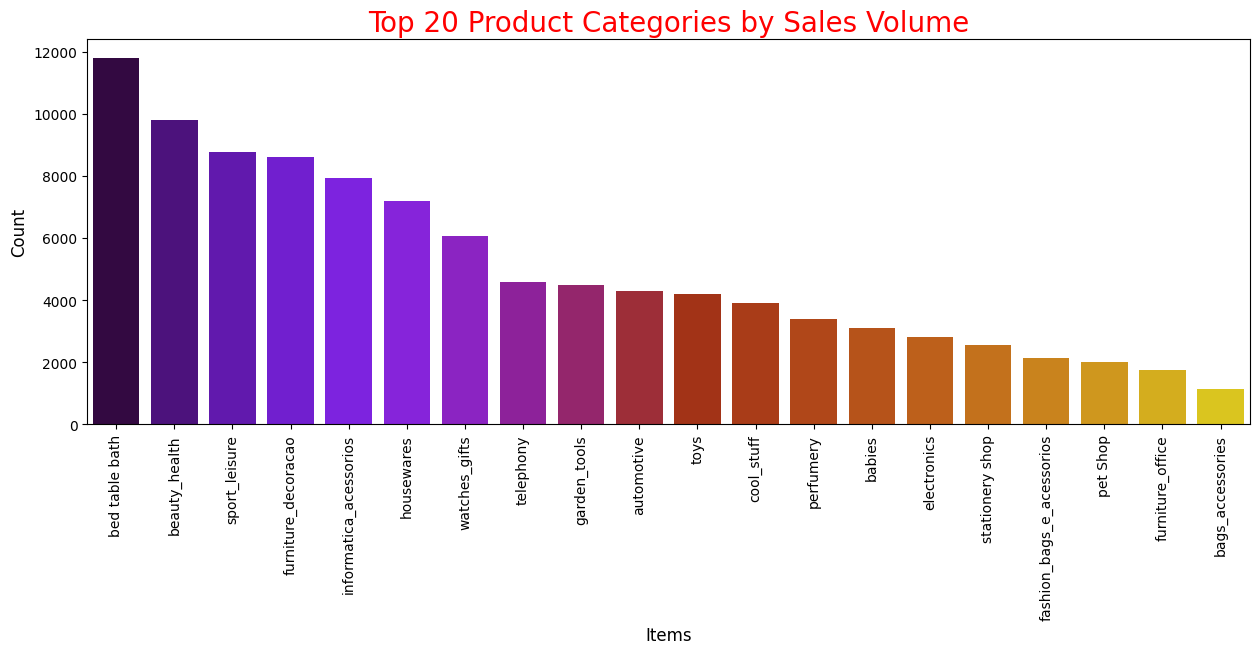

In [33]:
# Grouping data by product category
category= orders_info.groupby('product_category_name').size().sort_values(ascending=False)
plt.figure(figsize=(15,5))
sns.barplot(x = category.head(20).index, y = category.head(20).values, palette = 'gnuplot')
plt.xlabel('Items', size = 12)
plt.xticks(rotation=90)
plt.ylabel('Count', size = 12)
plt.title('Top 20 Product Categories by Sales Volume', color = 'Red', size = 20)
plt.show()

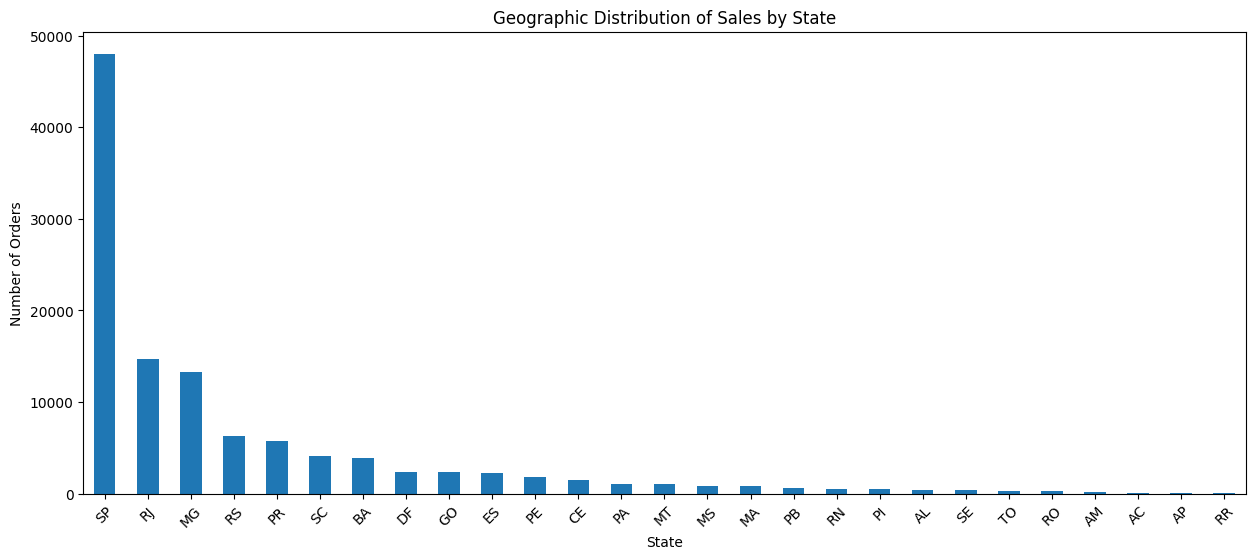

In [34]:
# Grouping data by customer state
state_sales = orders_info.groupby('customer_state').size().sort_values(ascending=False)

# Plotting sales distribution by state
plt.figure(figsize=(15, 6))
state_sales.plot(kind='bar')
plt.title('Geographic Distribution of Sales by State')
plt.xlabel('State')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()

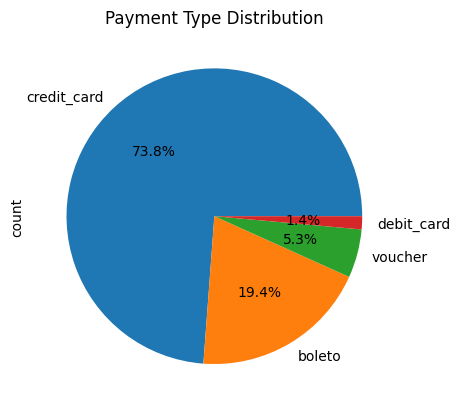

In [35]:
# payment type
orders_info['payment_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Payment Type Distribution')
plt.show()

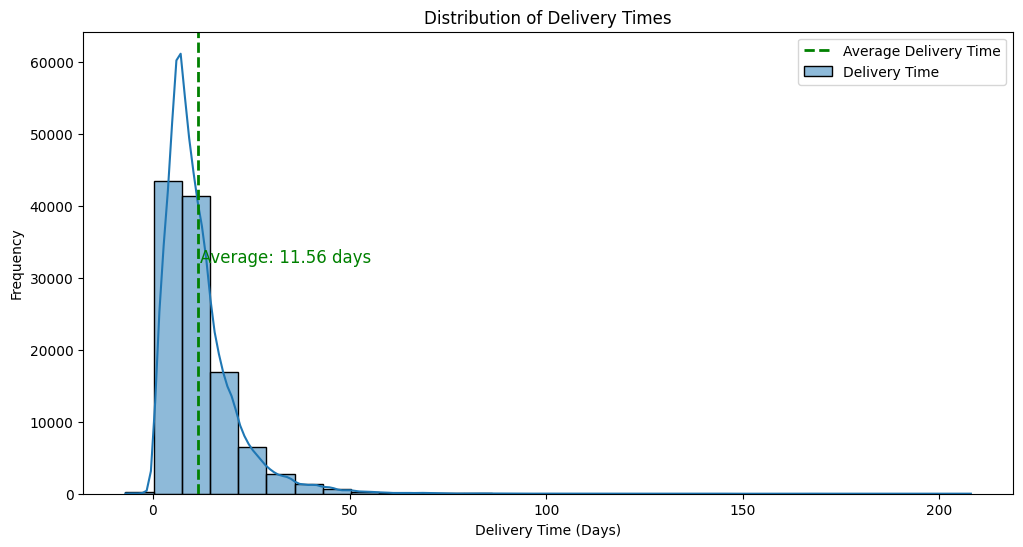

In [36]:
#Calculate the average delivery time
average_delivery_time = orders_info['time_to_delivery'].mean()

# Plot the distribution of delivery times
plt.figure(figsize=(12, 6))
sns.histplot(orders_info['time_to_delivery'].dropna(), bins=30, kde=True, label='Delivery Time')
plt.axvline(average_delivery_time, color='green', linestyle='dashed', linewidth=2, label='Average Delivery Time')
plt.text(average_delivery_time + 0.5, plt.ylim()[1] / 2, f'Average: {average_delivery_time:.2f} days', color='green', fontsize=12, ha='left')
plt.title('Distribution of Delivery Times')
plt.xlabel('Delivery Time (Days)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [37]:
monthly_delivery_status = orders_info.groupby('order_month').agg(
    avg_time_to_delivery=('time_to_delivery', 'mean'),
    proportion_late=('late_delivery', lambda x: (x > 0).mean())
).reset_index()

# Create a plot using Plotly
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add a bar for average Time to Delivery
fig.add_trace(
    go.Bar(x=monthly_delivery_status['order_month'], y=monthly_delivery_status['avg_time_to_delivery'],
           name='Avg. Time to Delivery (days)'),
    secondary_y=False,
)

# Add a line for the proportion of late deliveries
fig.add_trace(
    go.Scatter(x=monthly_delivery_status['order_month'], y=monthly_delivery_status['proportion_late'],
               name='Proportion of Late Deliveries', mode='lines+markers', marker=dict(color='red')),
    secondary_y=True,)
# Add titles and labels
fig.update_layout(
    title='Proportion of Late Delivery vs Average Time to Delivery in Monthly Trends',
    xaxis_title='Month',
    yaxis_title='Average Time to Delivery (days)',
    yaxis2_title='Proportion of Late Deliveries',
    legend=dict(y=0.5, traceorder='reversed', font_size=16)
)

# Show the plot
fig.show()

In [38]:
# Preparing the data
grouped_data = orders_info.groupby(['order_month', 'late_delivery'])['product_weight_g'].count().reset_index()
grouped_data = grouped_data.pivot(index='order_month', columns='late_delivery', values='product_weight_g').fillna(0)

# Creating the bar for each 'late_delivery' status
bars = []
for late_delivery_status in grouped_data.columns:
    bars.append(go.Bar(name=str(late_delivery_status),
                       x=grouped_data.index,
                       y=grouped_data[late_delivery_status]))

# Creating the figure and adding the bars
fig = go.Figure(data=bars)

# Change the bar mode to stacked
fig.update_layout(barmode='stack',
                  title='Count of Product Weight by Month and Late Delivery Status',
                  xaxis_title='Order Month',
                  yaxis_title='Count of Product Weight')

# Show the plot
fig.show()

<ipython-input-39-7a7780acdf8e>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




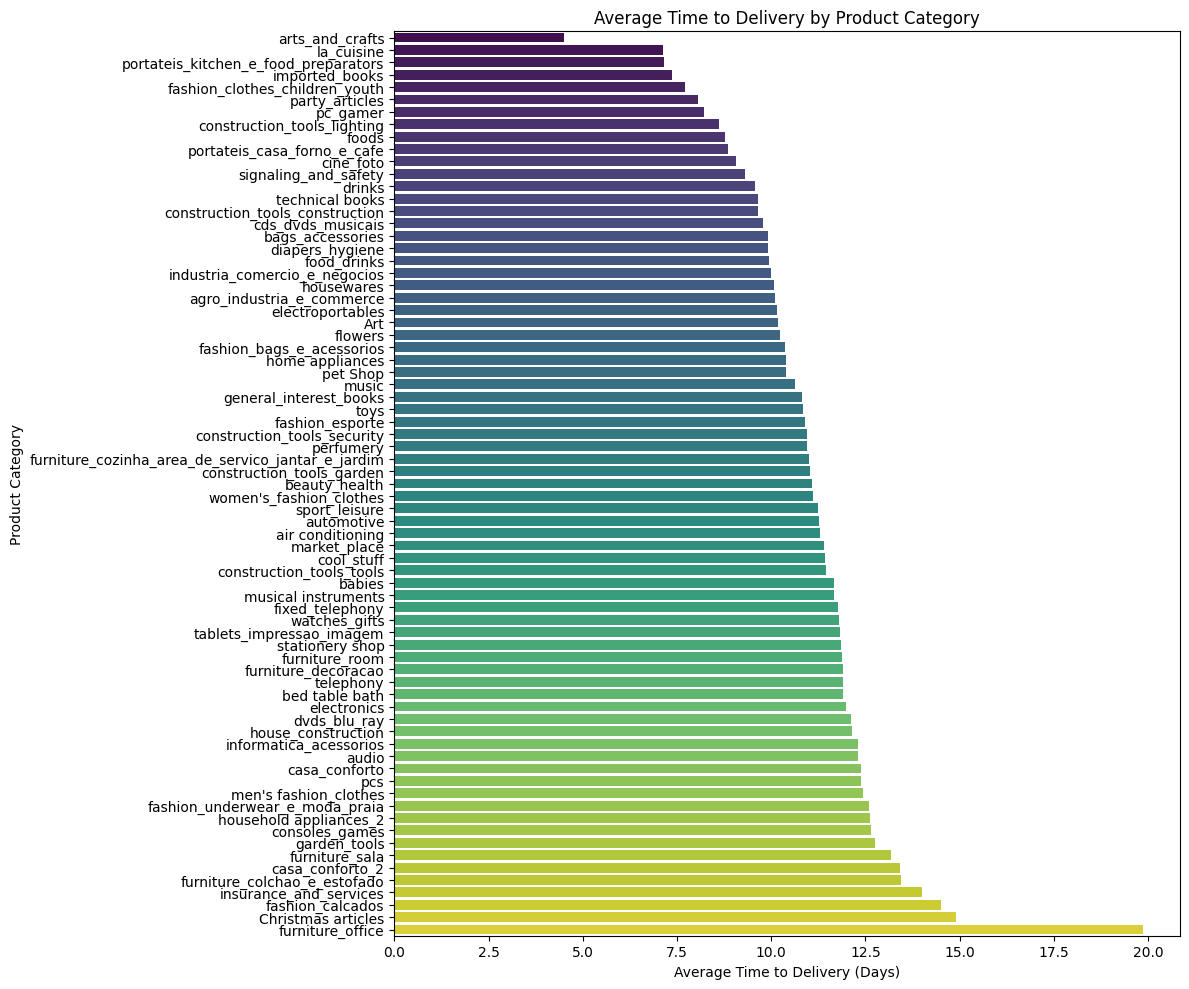

In [39]:
# Analyzing the Variability of Time to Delivery Across Different Product Categories
category_delivery_times = orders_info.groupby('product_category_name')['time_to_delivery'].mean().sort_values()

plt.figure(figsize=(12, 10))
sns.barplot(x=category_delivery_times.values, y=category_delivery_times.index, palette="viridis")
plt.title('Average Time to Delivery by Product Category')
plt.xlabel('Average Time to Delivery (Days)')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()